In [48]:
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
import os,json
import scipy.io as sio
import seaborn as sns
import pandas as pd
from operator import truediv
import spectral
from sklearn.manifold import TSNE
from sklearn.decomposition import (IncrementalPCA, PCA)
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.keras.layers import Dense, Dropout, Activation, Reshape, Concatenate
from tensorflow.keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

In [49]:
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'SA':
        HSI = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
        Num_Classes = 16
        target_names = ['Weeds_1','Weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth', 'Stubble','Celery',
                        'Grapes_untrained','Soil_vinyard_develop','Corn_Weeds',
                        'Lettuce_4wk','Lettuce_5wk','Lettuce_6wk',
                        'Lettuce_7wk', 'Vinyard_untrained','Vinyard_trellis']
    elif method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    elif method == 'UH':
      HSI = sio.loadmat(os.path.join(data_path, 'HU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'HU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names

In [50]:
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

In [51]:
def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)
    return Tr, Va, Te, TrC, VaC, TeC

In [52]:
HSID = "PU"
DLM = "PCA"
WS = 8
teRatio = 0.50
vrRatio = 0.90
trRatio = 0.10
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)
epochs = 5
batch_size = 56

/home/zhongruima/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
      image_cubes = image_cubes[patchesLabels>0,:,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
    return image_cubes, patchesLabels

In [54]:
def ClassificationReports(TeC, Te_Pred, target_names):
    classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1), target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

In [55]:
def CSVResults(file_name, classification, confusion, Parameters,
                Flops, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Flops'.format(Flops))
      CSV_file.write('\n')
      CSV_file.write('{} Parameters'.format(Parameters))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(oa))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(aa))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(each_acc))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(confusion))
    return CSV_file

In [56]:
## Plot Ground Truths
def GT_Plot(CRDHSI, GT, model, WS, k):
  Predicted = model.predict(CRDHSI)
  Predicted = np.argmax(Predicted, axis=1)
  height, width = np.shape(GT)
  ## Calculate the predicted Ground Truths
  outputs = np.zeros((height, width))
  count = 0
  for AA in range(height):
    for BB in range(width):
      target = int(GT[AA,BB])
      if target == 0:
        continue
      else:
        outputs[AA][BB] = Predicted[count]
        count = count+1
  return outputs

In [57]:
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
TrC = to_categorical(TrC)
VaC = to_categorical(VaC)
TeC = to_categorical(TeC)
CHSI = to_categorical(CGT)

In [ ]:
# Compute the Flops
import tensorflow as tf

try:
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
    def _freeze_to_graph_def(concrete_fn):
        frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_fn)
        return graph_def
except Exception:
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    def _freeze_to_graph_def(concrete_fn):
        frozen_func = convert_variables_to_constants_v2(concrete_fn)
        return frozen_func.graph.as_graph_def(add_shapes=True)

def compute_flops(model, sample_input, training=False, return_macs=False):
    # 1) 先跑一遍，确保所有“用得到”的层都被 build
    _ = model(sample_input, training=training)

    # 2) 包成 tf.function 并具体化
    @tf.function(experimental_relax_shapes=True)
    def _wrapped(x):
        return model(x, training=training)
    concrete = _wrapped.get_concrete_function(
        tf.TensorSpec(sample_input.shape, dtype=sample_input.dtype)
    )

    # 3) 冻结为静态图
    graph_def = _freeze_to_graph_def(concrete)

    # 4) 用 v1 profiler 统计 total_float_ops（FLOPs）
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)

    total_flops = int(flops.total_float_ops) if flops is not None else 0
    return total_flops // 2 if return_macs else total_flops  # return_macs=True 时给 MACs


In [59]:
# Count samples per class
def count_class_samples(labels, num_classes):
    class_counts = {f"class_{i}": 0 for i in range(num_classes)}
    for label in labels:
        class_index = np.argmax(label)
        class_counts[f"class_{class_index}"] += 1
    return class_counts

In [ ]:
class SpectralSpatialTokenGeneration(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        # x: (B, H, W, C)
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]

        # 你的原始实现等价于把图像展平到 L = H*W，再做 Dense
        L = H * W
        flat = tf.reshape(x, [B, L, C])              # (B, L, C)

        spatial_tokens  = self.spatial_tokens(flat)  # (B, L, out_channels)
        spectral_tokens = self.spectral_tokens(flat) # (B, L, out_channels)
        return spatial_tokens, spectral_tokens

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout=0.1, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.all_head_size = self.num_heads * self.head_dim
        self.query = Dense(self.all_head_size)
        self.key = Dense(self.all_head_size)
        self.value = Dense(self.all_head_size)
        self.dropout = Dropout(dropout)
    def call(self, query, key, value):
        # query/key/value: (B, L, E)
        B = tf.shape(query)[0]
        L = tf.shape(query)[1]

        q = self.query(query)   # (B, L, all_head)
        k = self.key(key)
        v = self.value(value)

        def split_heads(t):
            t = tf.reshape(t, [B, L, self.num_heads, self.head_dim])  # (B, L, H, D)
            return tf.transpose(t, [0, 2, 1, 3])                      # (B, H, L, D)

        q = split_heads(q)
        k = split_heads(k)
        v = split_heads(v)

        # 注意力分数
        scale = tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        scores = tf.matmul(q, k, transpose_b=True) / scale            # (B, H, L, L)
        weights = tf.nn.softmax(scores, axis=-1)                      # (B, H, L, L)

        attn = tf.matmul(weights, v)                                  # (B, H, L, D)
        attn = tf.transpose(attn, [0, 2, 1, 3])                       # (B, L, H, D)
        attn = tf.reshape(attn, [B, L, self.all_head_size])           # (B, L, E)
        attn = self.dropout(attn)
        return attn

In [62]:
class SpectralSpatialFeatureEnhancement(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced

In [ ]:
class _SSMCell(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super().__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update     = Dense(state_dim)

    @property
    def state_size(self):
        return self.state_dim

    def call(self, inputs, states):
        # inputs: (B, E), states[0]: (B, state_dim)
        prev_state = states[0]
        new_state = self.state_transition(prev_state) + self.state_update(inputs)
        return new_state, [new_state]
    
class StateSpaceModel(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel, self).__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(_SSMCell(state_dim),
                                       return_sequences=False,
                                       return_state=False)
    def call(self, x):
        return self.rnn(x)   # (B, state_dim)
        

In [64]:
class SSMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, dropout=0.1, **kwargs):
        super(SSMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        self.multi_head_attention = MultiHeadAttention(out_channels, num_heads, dropout)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement(out_channels)
        self.state_space_model = StateSpaceModel(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def set_num_classes(self, n):
        self.num_classes = int(n)
        self.classifier = Dense(self.num_classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        attention_output = self.multi_head_attention(spatial_enhanced, spectral_enhanced, spectral_enhanced)
        state_output = self.state_space_model(attention_output)
        output = self.classifier(state_output)
        return output


In [65]:
# Uncertainty Sampling
def uncertainty_sampling(model, X_pool, query_size):
    probs = model.predict(X_pool)
    uncertainty = -np.max(probs, axis=1)  # Lower max prob indicates higher uncertainty
    query_indices = np.argsort(uncertainty)[-query_size:]  # Get indices of most uncertain samples
    return query_indices

In [66]:
# Diversity Sampling 
def diversity_sampling(X_pool, query_size):
    num_samples, H, W, C = X_pool.shape
    query_indices = []
    neighborhood_size=3
    half_size = neighborhood_size // 2
    for i in range(num_samples):
        current_sample = X_pool[i]
        diversity_values = np.zeros((H, W))
        for h in range(half_size, H - half_size):
            for w in range(half_size, W - half_size):
                neighborhood = current_sample[h - half_size:h + half_size + 1, w - half_size:w + half_size + 1, :]
                reshaped_neighborhood = neighborhood.reshape(-1, C)
                distances = cdist(reshaped_neighborhood, reshaped_neighborhood, metric='euclidean')
                diversity_metric = np.mean(distances)
                diversity_values[h, w] = diversity_metric
        flat_diversity_values = diversity_values.flatten()
        query_indices = np.argsort(flat_diversity_values)[-query_size:]
    return query_indices

In [67]:
# Hybrid Query
def hybrid_query_strategy(model, X_pool, query_size):
    uncertainty_indices = uncertainty_sampling(model, X_pool, query_size)
    diversity_indices = diversity_sampling(X_pool, query_size)
    query_indices = np.unique(np.concatenate((uncertainty_indices, diversity_indices)))
    return query_indices[:query_size]

In [68]:
# ATL-MHSSMamba
def main_pipeline(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, num_iterations, query_percentage, epochs, batch_size):  
    model = SSMambaModel(out_channels=64, num_heads=4, state_dim=128, dropout=0.1)
    _ = model(Tr[:batch_size])
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Initialize a dictionary to store sample counts
    sample_counts = {
        "initial_training_samples": Tr.shape[0],
        "initial_Train_class_counts": count_class_samples(TrC, Num_Classes),
        "initial_validation_samples": Va.shape[0],
        "initial_Val_class_counts": count_class_samples(VaC, Num_Classes),
        "Test_samples": Te.shape[0],
        "class_Test_counts": count_class_samples(TeC, Num_Classes),
        "iterations": []
    }

    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    Tr_Time = time.time() - start

    # initial_flops = compute_flops(model)
    dummy = tf.zeros((1, WS, WS, k), dtype=tf.float32)  # 或用 tf.zeros_like(Tr[:1])
    initial_flops = compute_flops(model, dummy, training=False, return_macs=False)

     # Record initial counts
    sample_counts["iterations"].append({
        "iteration": 1,
        "training_samples": Tr.shape[0],
        "class_train_counts": count_class_samples(TrC, Num_Classes),
        "validation_samples": Va.shape[0],
        "class_Val_counts": count_class_samples(VaC, Num_Classes), 
        "Test_samples": Te.shape[0],
        "class_Test_counts": count_class_samples(TeC, Num_Classes)
    })
    
    start = time.time()
    Te_Pre = model.predict(Te)
    end = time.time()
    Te_Time = end - start
    trainable_parameters = model.count_params()
    classification,Confusion,OA,Per_Class,AA,Kappa = ClassificationReports(TeC, Te_Pre, target_names)
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Classification_Report.csv"
    CSV_file = CSVResults(file_name, classification, Confusion, trainable_parameters, 
                          initial_flops, Tr_Time, Te_Time, DL_Time, Kappa, OA, AA, Per_Class)
    
    # Ground Truths for inital Training
    outputs = GT_Plot(CRDHSI, GT, model, WS, k)
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Ground_Truths.png"
    plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)

     # Active Learning Iterations
    for i in range(1, num_iterations+1):
        print(f"Active Learning Iteration {i}/{num_iterations}")
        # Query new samples from the pool using uncertainty sampling
        query_size = int(query_percentage * Va.shape[0])
        query_indices = hybrid_query_strategy(model, Va, query_size)
        queried_X = Va[query_indices]
        queried_y = VaC[query_indices]
        
        # Add queried samples back to the training set
        Tr = np.concatenate([Tr, queried_X], axis=0)
        TrC = np.concatenate([TrC, queried_y], axis=0)
        # Remove queried samples from the pool
        Va = np.delete(Va, query_indices, axis=0)
        VaC = np.delete(VaC, query_indices, axis=0)
        # Record counts after querying
        sample_counts["iterations"].append({
            "iteration": i+1,
            "training_samples": Tr.shape[0],
            "class_train_counts": count_class_samples(TrC, Num_Classes),
            "validation_samples": Va.shape[0],
            "class_Val_counts": count_class_samples(VaC, Num_Classes)
        })
        # freeze feature learning layers and fine-tune classification layers
        for layer in model.layers[:-3]:
            layer.trainable = False
        # Fine-tuning the model
        fine_tune_start_time = time.time()
        history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
        fine_tune_time = time.time() - fine_tune_start_time
        # Compute FLOPs for the Fine_tuned model
        # Fine_tuned_flops = compute_flops(model)
        dummy = tf.zeros((1, WS, WS, k), dtype=tf.float32)
        Fine_tuned_flops = compute_flops(model, dummy, training=False, return_macs=False)

        Finetuned_parameters = model.count_params()
        ## Test Phase 
        start = time.time()
        Te_Pre = model.predict(Te)
        end = time.time()
        Te_Time = end - start
        ## Classification Report for Test Model
        classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
        file_name = f"{i+1}_{HSID}_{trRatio}_{WS}_Classification_Report.csv"
        CSV_file = CSVResults(file_name, classification, Confusion, Finetuned_parameters, 
                          Fine_tuned_flops, fine_tune_time, Te_Time, DL_Time, Kappa, OA, AA, Per_Class)
        # Ground Truths
        outputs = GT_Plot(CRDHSI, GT, model, WS, k)
        plt.figure(figsize=(10, 10))
        plt.imshow(outputs, cmap='nipy_spectral')
        plt.axis('off')
        file_name = f"{i+1}_{HSID}_{trRatio}_{WS}_Ground_Truths.png"
        plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
        # Save the model during the last iteration
        if i == num_iterations:
            model.save(f"{HSID}_trained_ssmamba_model.tf")
            print(f"Model saved at iteration {i} as 'final_model_iteration.tf'")

    # Save sample counts to a file
    sample_counts_filename = f"{HSID}_{trRatio}_{WS}_sample_counts.json"
    with open(sample_counts_filename, 'w') as f:
        json.dump(sample_counts, f, indent=4)    
    # Extract training and validation metrics
    accuracy = history.history['accuracy']
    loss = history.history['loss']
        # Check if validation metrics exist
    val_accuracy = history.history.get('val_accuracy', [])
    val_loss = history.history.get('val_loss', [])
    # Create a DataFrame
    history_df = pd.DataFrame({
        'Epoch': range(1, len(accuracy) + 1),
        'Training Accuracy': accuracy,
        'Training Loss': loss,
        'Validation Accuracy': val_accuracy if val_accuracy else ['N/A'] * len(accuracy),
        'Validation Loss': val_loss if val_loss else ['N/A'] * len(accuracy)
    })
    # Save to CSV
    history_df.to_csv(f"{HSID}_training_history.csv", index=False)
    return model
# Main
model = main_pipeline(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, num_iterations=5, 
                      query_percentage=0.02, epochs=epochs, batch_size=batch_size)

Epoch 1/5
 5/39 [==>...........................] - ETA: 3s - loss: 1.9438 - accuracy: 0.3607

KeyboardInterrupt: 

[OK] Loaded old SSMamba from: PU_trained_ssmamba_model.tf
Epoch 1/5
27/27 [==============================] - 4s 125ms/step - loss: 6.2770 - accuracy: 0.1498 - val_loss: 2.9505 - val_accuracy: 0.2864
Epoch 2/5
27/27 [==============================] - 3s 120ms/step - loss: 2.1151 - accuracy: 0.4487 - val_loss: 1.5991 - val_accuracy: 0.5592
Epoch 3/5
27/27 [==============================] - 3s 120ms/step - loss: 1.5546 - accuracy: 0.5766 - val_loss: 1.4072 - val_accuracy: 0.5993
Epoch 4/5
27/27 [==============================] - 3s 113ms/step - loss: 1.4294 - accuracy: 0.6025 - val_loss: 1.3370 - val_accuracy: 0.6226
Epoch 5/5
27/27 [==============================] - 3s 108ms/step - loss: 1.3718 - accuracy: 0.6258 - val_loss: 1.2976 - val_accuracy: 0.6475


2025-09-04 11:31:31.211209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-04 11:31:31.211263: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-09-04 11:31:31.211382: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-04 11:31:31.211694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-04 11:31:31.211724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-04 11:31:31.211736: I external/local_xla/xl


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

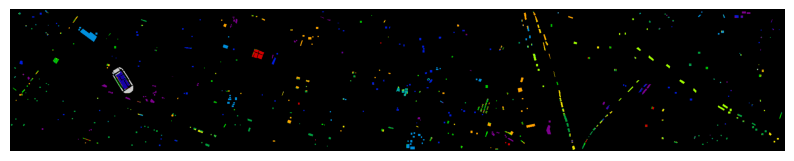

In [69]:
## Across data classification
## Load the Model
from tensorflow.keras.models import load_model
OLD_MODEL_PATH = "PU_trained_ssmamba_model.tf"
customs = {
    "SpectralSpatialTokenGeneration": SpectralSpatialTokenGeneration,
    "SpectralSpatialFeatureEnhancement": SpectralSpatialFeatureEnhancement,
    "MultiHeadAttention": MultiHeadAttention,       # 如果你仍用这个类名，则也提供
    "StateSpaceModel": StateSpaceModel,
    "_SSMCell": _SSMCell,
    "SSMambaModel": SSMambaModel,
}

trained_model = load_model(
    OLD_MODEL_PATH,   # 或 .keras
    custom_objects=customs,
    compile=False,
    safe_mode=False
)
print(f"[OK] Loaded old SSMamba from: {OLD_MODEL_PATH}")
# 新数据集
HSID = "UH"
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
RDHSI = DLMethod(DLM, HSI, NC=k)
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS=WS)
Tr, Va, Te, TrC_idx, VaC_idx, TeC_idx = TrTeSplit(CRDHSI, CGT, 0.2, 0.8, 0.5)
TrC = to_categorical(TrC_idx, num_classes=Num_Classes)
VaC = to_categorical(VaC_idx, num_classes=Num_Classes)
TeC = to_categorical(TeC_idx, num_classes=Num_Classes)

# Retrain the model (freeze feature learning layers and fine-tune classification layer)
# 1) 冻结骨干
for sub in [trained_model.token_generation,
            trained_model.multi_head_attention,
            trained_model.feature_enhancement,
            trained_model.state_space_model]:
    sub.trainable = False

# 2) 用新数据集的类别数，直接替换分类头
trained_model.classifier = tf.keras.layers.Dense(Num_Classes, activation='softmax', name='classifier')

# 3) 走一遍前向，构建新头
_ = trained_model(tf.zeros((1, WS, WS, k), dtype=tf.float32))

# 4) 编译 & 训练
trained_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model= trained_model  # 直接用这个模型继续训练

# # 新实例（类别数 = 新数据集）
# new_mamba = SSMambaModel(out_channels=64, num_heads=4, state_dim=128, dropout=0.1)
# new_mamba.set_num_classes(Num_Classes)
# _ = new_mamba(tf.zeros((1, WS, WS, k), dtype=tf.float32))  # build

# # 从旧模型把“骨干”权重拷到新模型（分类头保持新）
# new_mamba.token_generation.set_weights(trained_model.token_generation.get_weights())
# new_mamba.multi_head_attention.set_weights(trained_model.multi_head_attention.get_weights())
# new_mamba.feature_enhancement.set_weights(trained_model.feature_enhancement.get_weights())
# new_mamba.state_space_model.set_weights(trained_model.state_space_model.get_weights())

# # 冻结骨干，编译、微调、评估、写 CSV/画图 —— 与方案 A 相同
# for sub in [new_mamba.token_generation, new_mamba.multi_head_attention, new_mamba.feature_enhancement, new_mamba.state_space_model]:
#     sub.trainable = False

# new_mamba.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# ---------- 6) 微调 ----------
fine_tune_start_time = time.time()
history = model.fit(Tr, TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
fine_tune_time = time.time() - fine_tune_start_time

# ---------- 7) FLOPs / 参数量 ----------
dummy = tf.zeros((1, WS, WS, k), dtype=tf.float32)
Fine_tuned_flops = compute_flops(model, dummy, training=False, return_macs=False)  # FLOPs
Finetuned_parameters = model.count_params()

# ---------- 8) 测试评估 ----------
start = time.time()
Te_Pre = model.predict(Te)
Te_Time = time.time() - start

classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
print(classification)

# ---------- 9) 写 CSV（与你的 CSVResults 签名完全对齐） ----------
# 若你没有 DL_Time，可用 0.0 占位
DL_Time = 0.0
file_name = f"{HSID}_{trRatio}_{WS}_Classification_Report.csv"
_ = CSVResults(
    file_name=file_name,
    classification=classification,
    confusion=Confusion,
    Parameters=Finetuned_parameters,
    Flops=Fine_tuned_flops,
    Tr_Time=fine_tune_time,
    Te_Time=Te_Time,
    DL_Time=DL_Time,
    kappa=Kappa,
    oa=OA,
    aa=AA,
    each_acc=Per_Class
)
print(f"[OK] Saved CSV: {file_name}")

# ---------- 10) 生成伪彩标注图 ----------
Predicted = model.predict(CRDHSI)
Predicted = np.argmax(Predicted, axis=1)
height, width = np.shape(GT)
outputs = np.zeros((height, width))
cnt = 0
for aa in range(height):
    for bb in range(width):
        tgt = int(GT[aa, bb])
        if tgt == 0:
            continue
        outputs[aa][bb] = Predicted[cnt]
        cnt += 1

plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
plt.axis('off')
png_name = f"{HSID}_{trRatio}_{WS}_Ground_Truths.png"
plt.savefig(png_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
print(f"[OK] Saved map: {png_name}")



In [ ]:
# ---------- 11) 训练曲线保存 ----------
acc = history.history.get('accuracy', [])
loss = history.history.get('loss', [])
val_acc = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])
history_df = pd.DataFrame({
    'Epoch': list(range(1, len(acc) + 1)),
    'Training Accuracy': acc,
    'Training Loss': loss,
    'Validation Accuracy': val_acc if val_acc else ['N/A'] * len(acc),
    'Validation Loss': val_loss if val_loss else ['N/A'] * len(acc),
})
hist_csv = f"{HSID}_training_history.csv"
history_df.to_csv(hist_csv, index=False)
print(f"[OK] Saved history: {hist_csv}")

[OK] Saved history: SA_training_history.csv
